# Age Trends Among Olympic Athletes
## by David Kobilnyk

## Investigation Overview

In this investigation, I wanted to look at the age trends of Olympic athletes over time. Are they getting younger or older, and are there subsets of athletes that show different patterns?

## Dataset Overview

The dataset consists of information regarding about 270,000 Olympic athlete/event combinations for Olympic games from 1896 to 2016, including Sex, Age, Country, Sport, Medal, and more. About 10,000 rows were removed due to missing Age information, and another approximately 5,000 were removed for being related to activities that were not as interesting for the analysis.

In [1]:
# Standard library
import itertools
import math
import random
import time


# Data science tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Pandas defaults.
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)


# Suppress warnings from final output.
import warnings
warnings.simplefilter("ignore")


# Set up some chart defaults.
%matplotlib inline
plt.rcParams.update({'font.size': 14})
default_figwidth = 9
default_figheight = 9
default_figsize = (default_figwidth, default_figheight)
plt.figure(figsize=default_figsize);

<Figure size 648x648 with 0 Axes>

In [2]:
# Some helpful chart functions.
def centered_bins_of_size_from_series(size, series):
    min_x, max_x = series.agg(['min', 'max']).tolist()
    bins = np.arange(min_x, max_x + size + 1, size) - (size / 2)
    return bins

def histogram_of_series_with_bin_size(series, size, figsize=default_figsize):
    bins = centered_bins_of_size_from_series(size, series)
    series.hist(bins=bins, figsize=figsize)

def barplot_of_top_n_of_series(n, series, figsize=default_figsize):
    (
        series
        .value_counts()
        .head(n)
        .sort_values()
        .plot(kind='barh', figsize=figsize, color='C0')
    )

def labels_title(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def use_default_year_settings_for_x_axis(year_gap=12):
    plt.xlim(1895, 2017)
    year_ticks = range(1896, 2017, year_gap)
    plt.xticks(year_ticks, year_ticks)

def get_weights_for_norm_hist(df, groupby_col, percent=True):
    counts = df.groupby(groupby_col).count().iloc[:, 0].tolist()
    weights = np.array(list(itertools.chain(*[[1/n] * n for n in counts])))
    return weights * (100 if percent else 1)

# From https://stackoverflow.com/a/31302882/576101.
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)

def repeat_facetgrid_ticklabels():
    # From https://stackoverflow.com/a/52184614/576101.
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)




In [3]:
df_explore = pd.read_csv('df_explore.csv', index_col=0)
df_athletes_explore = pd.read_csv('df_athletes_explore.csv', index_col=0)
df_season_athletes_explore = (
    pd.read_csv('df_season_athletes_explore.csv', index_col=0)
)
df_season_athletes_explore.rename_axis('SeasonAthleteID', inplace=True)

df_explore_recent = df_explore[df_explore.Year >= 2014].copy()

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Mean Age of Olympic Athletes by Year, Season, and Gender

There is a lot of volatility in the early years, especially for females, perhaps attributable to smaller quantity of age data for those earlier years.

The two peaks around 1920 and 1948 mostly coincide with post-war games. Perhaps many athletes who had planned on competing in the canceled 1916, 1940, or 1944 games waited (and aged) until the next Olympics season, or many younger would-be athletes were unable to practice for the Olympics during the harsh war years.

After the second Olympics, there is overall a large decrease in mean age until around 1980. The minimums for Summer and for females precede those of Winter and males a little bit.

The large increase from around 1980 on may be caused by the increasing acceptance of professional athletes into the Olympics.

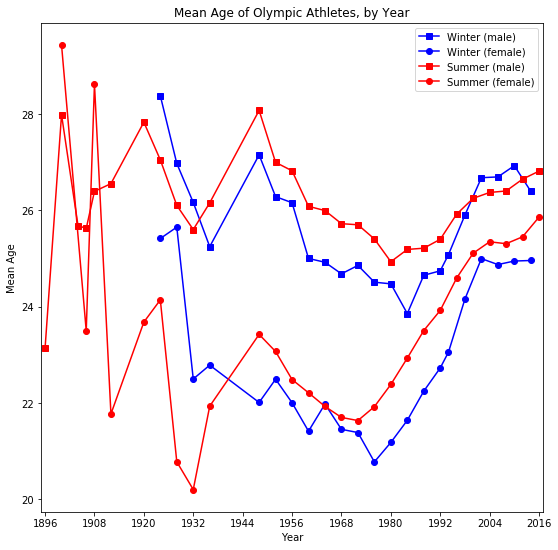

In [15]:
female = df_explore.IsFemale
male = ~df_explore.IsFemale
winter = df_explore.Season == 'Winter'
summer = df_explore.Season == 'Summer'

def remove_duplicate_athletes_by_year(df):
    return (
        df.groupby(['AthleteID', 'Year'])
        .Age.mean() # or min() or max(): the ages are same for a given athlete.
        .to_frame()
        .reset_index()
    )

def age_mean_by_year(df):
    return remove_duplicate_athletes_by_year(df).groupby('Year').Age.mean()

female_winter_age_by_year = age_mean_by_year(df_explore[female & winter])
female_summer_age_by_year = age_mean_by_year(df_explore[female & summer])
male_winter_age_by_year = age_mean_by_year(df_explore[male & winter])
male_summer_age_by_year = age_mean_by_year(df_explore[male & summer])

plt.figure(figsize=default_figsize)
plt.plot(male_winter_age_by_year, color='b', label='Winter (male)', marker='s');
plt.plot(
    female_winter_age_by_year, color='b', label='Winter (female)', marker='o');
plt.plot(male_summer_age_by_year, color='r', label='Summer (male)', marker='s');
plt.plot(
    female_summer_age_by_year, color='r', label='Summer (female)', marker='o');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age of Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

## (Visualization 1)

> Write a comment about your visualization here. The visualization should be in
the next cell, as a sub-slide type. Make sure your visualizations are polished!

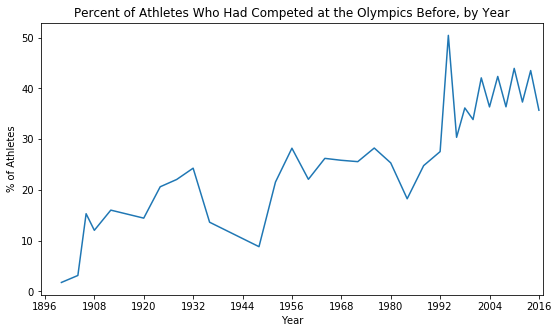

In [5]:
n_repeat_athletes_by_year = (
    (df_explore[['AthleteID', 'NPreviousSeasons', 'Year']]
    .groupby(['Year', 'AthleteID'])
    .max()
    .NPreviousSeasons > 0)
    .replace(False, np.NaN)
    .dropna()
    .to_frame()
    .reset_index()
    ['Year']
    .value_counts()
)
n_athletes_by_year = (
    df_explore[['AthleteID', 'Year']]
    .groupby(['Year', 'AthleteID'])
    .count()
    .reset_index()
    ['Year']
    .value_counts()
)
percent_repeat_athletes_by_year = (
    n_repeat_athletes_by_year / n_athletes_by_year * 100
)
plt.figure(figsize=(default_figwidth, 5))
plt.plot(percent_repeat_athletes_by_year)
# sns.regplot(
#     x=percent_repeat_athletes_by_year.index.tolist(),
#     y=percent_repeat_athletes_by_year
# )
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% of Athletes',
    'Percent of Athletes Who Had Competed at the Olympics Before, by Year'
)

## (Visualization 2)

> You should have at least three visualizations in your presentation,
but feel free to add more if you'd like!

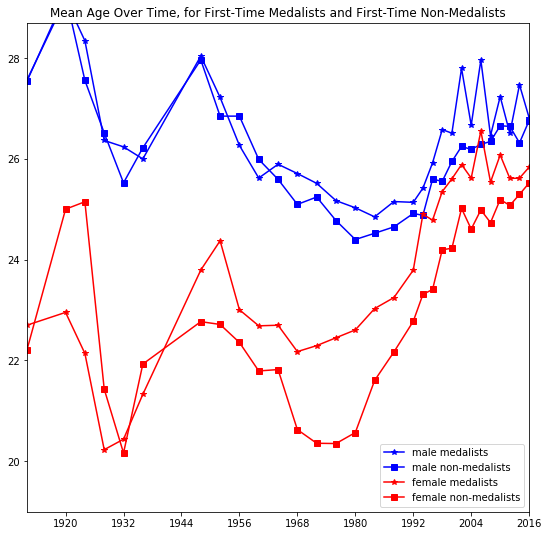

In [6]:
df_age_by_year_medal = (
    df_explore#[(df_explore.NPreviousSeasons == 0)]
    .groupby(['Year', 'Sex', 'WonMedal']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
male = df_age_by_year_medal.Sex == 'M'
won_medal = df_age_by_year_medal.WonMedal

plt.plot(df_age_by_year_medal[male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='*', color='b', label='male medalists')

plt.plot(df_age_by_year_medal[male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='s', color='b', label='male non-medalists')

plt.plot(df_age_by_year_medal[~male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='*', color='r', label='female medalists')
plt.plot(df_age_by_year_medal[~male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='s', color='r', label='female non-medalists')


plt.title(
    'Mean Age Over Time, for First-Time Medalists and First-Time Non-Medalists'
)
use_default_year_settings_for_x_axis()
plt.xlim(1912, 2016)
plt.ylim(19, 28.7);
plt.legend();

## (Visualization 3)



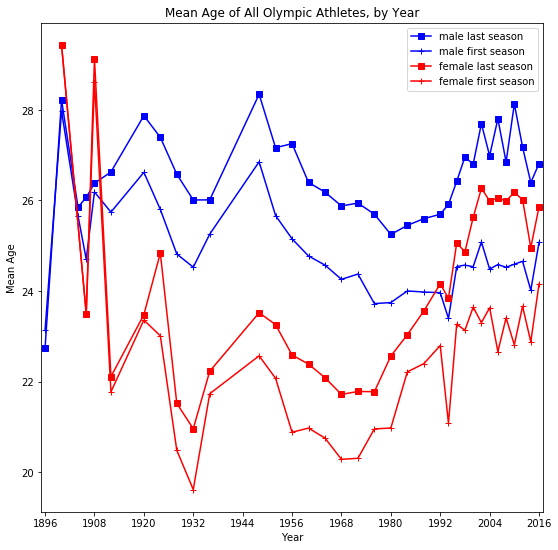

In [7]:
df_explore_male = df_explore[~df_explore.IsFemale]
df_explore_female = df_explore[df_explore.IsFemale]

male_age_by_year = (
    df_explore_male
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
# is_retiring = (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
male_retirees_by_year = (
    df_explore_male[
        (df_explore_male.NSeasons == df_explore_male.NPreviousSeasons + 1) 
#         &
#         (df_explore_male.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
male_new_by_year = (
    df_explore_male[
        (df_explore_male.NPreviousSeasons == 0)
#         &
#         (df_explore_male.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
male_onetimer_by_year = (
    df_explore_male[
        (df_explore_male.NPreviousSeasons == 0) &
        (df_explore_male.NSeasons == 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)

plt.figure(figsize=default_figsize)
# plt.plot(age_by_year);
plt.plot(male_retirees_by_year, color='b', label='male last season', marker='s');
plt.plot(male_new_by_year, color='b', label='male first season', marker='+');
# plt.plot(male_onetimer_by_year, color='k', label='male one-timer', marker='o');



female_age_by_year = (
    df_explore_female
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
# is_retiring = (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
female_retirees_by_year = (
    df_explore_female[
        (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
#         &
#         (df_explore_female.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
female_new_by_year = (
    df_explore_female[
        (df_explore_female.NPreviousSeasons == 0)
#         &
#         (df_explore_female.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
female_onetimer_by_year = (
    df_explore_female[
        (df_explore_female.NPreviousSeasons == 0) &
        (df_explore_female.NSeasons == 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)

# plt.figure(figsize=default_figsize)
# plt.plot(age_by_year);
plt.plot(female_retirees_by_year, color='r', label='female last season', marker='s');
plt.plot(female_new_by_year, color='r', label='female first season', marker='+');
# plt.plot(female_onetimer_by_year, color='b', label='female one-timer', marker='o');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age of All Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

## (Visualization 4)



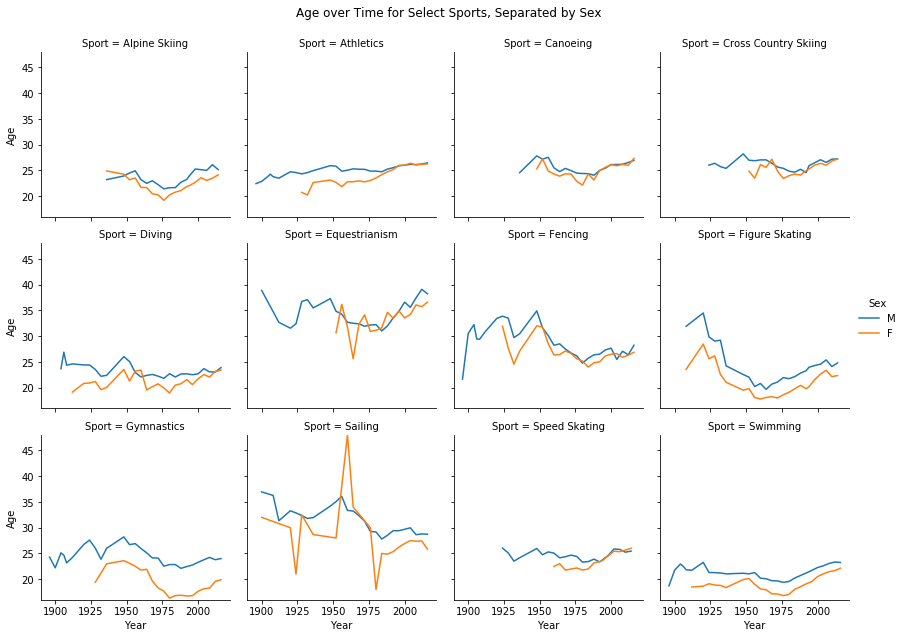

In [8]:
n_female_years_per_sport = (
    df_explore[df_explore.IsFemale]
    .groupby(['Sport', 'Year'])
    .AthleteID.count().to_frame().reset_index()
    .groupby('Sport').Year.count().sort_values()
)
most_freq_f_sports = sorted(n_female_years_per_sport.tail(12).index.tolist())

age_by_year_sport_sex = (
    df_explore
    [df_explore.Sport.isin(most_freq_f_sports)]
    .groupby(['Year', 'Sport', 'Sex'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_sport_sex,
    hue='Sex',
    hue_order=['M', 'F'],
    col='Sport',
    col_wrap=4,
    col_order=most_freq_f_sports
)
plt.ylim(16, 48)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.91)
g.fig.suptitle('Age over Time for Select Sports, Separated by Sex');
g.add_legend();

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!